# Seurat clustering 72h

In [61]:
library(Seurat)
library(ggplot2)
library(SingleR)
library(dplyr)
library(celldex)
library(RColorBrewer)
library(SingleCellExperiment)
library(repr)



ERROR: Error in library(SingleR): there is no package called ‘SingleR’


In [62]:
Gastruloid_72h_afterQC <- readRDS("./files/Seurat_Obj_afterQC/Gastruloid_72h_afterQC.rds")

# Processing of the data

In [63]:
mGast.list <- list(Gastruloid_72h_afterQC)
mGast.list <- lapply(X = mGast.list, FUN = function(x) {
  x <- NormalizeData(x, verbose = FALSE)
  x <- FindVariableFeatures(x, verbose = FALSE)
  x <- ScaleData(x, verbose = FALSE)
  x <- RunPCA(x, verbose = FALSE)
  x <- RunUMAP(x, dims = 1:30, n.neighbors=10)
  x <- FindNeighbors(x, dims = 1:20)
  x <- FindClusters(x, resolution = 0.3)
  
})
Gastruloid_72h_afterQC <- mGast.list[[1]]

16:27:12 UMAP embedding parameters a = 0.9922 b = 1.112

16:27:12 Read 2361 rows and found 30 numeric columns

16:27:12 Using Annoy for neighbor search, n_neighbors = 10

16:27:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:27:12 Writing NN index file to temp file /scratch/local/RtmpirVYrV/fileb993fa23b9c

16:27:12 Searching Annoy index using 1 thread, search_k = 1000

16:27:13 Annoy recall = 100%

16:27:13 Commencing smooth kNN distance calibration using 1 thread

16:27:14 Initializing from normalized Laplacian + noise

16:27:14 Commencing optimization for 500 epochs, with 33310 positive edges

16:27:16 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2361
Number of edges: 89932

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8510
Number of communities: 4
Elapsed time: 0 seconds


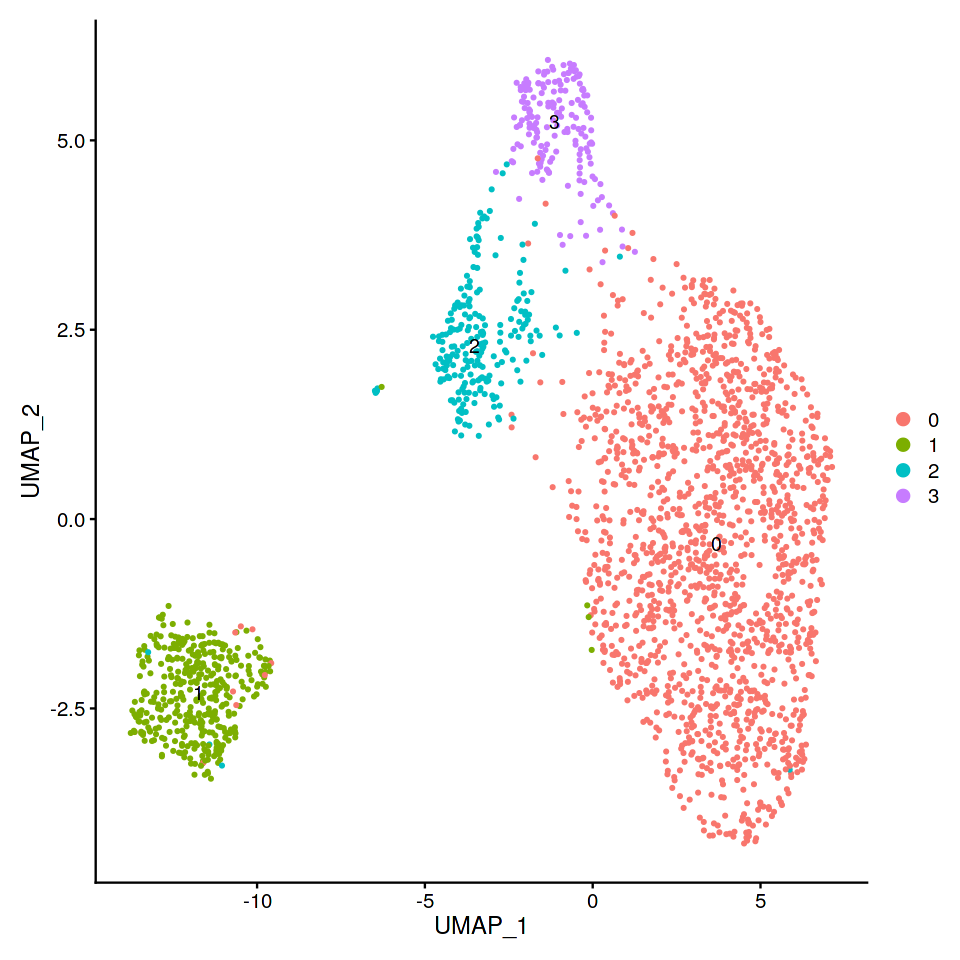

In [64]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(Gastruloid_72h_afterQC, label = T)

# Cell cycle scoring

In [65]:
# Cell cycle scoring and regression

# Reading cell cycle file 
cell.cycle <- read.table("../files/Macosko_cell_cycle_genes.txt", header = T, sep = '\t')
s.genes <- cell.cycle$S
s.genes <- paste(toupper(substr(s.genes, 1, 1)), substr(tolower(s.genes), 2, nchar(s.genes)), sep="")
g2m.genes <- cell.cycle$G2.M
g2m.genes <- paste(toupper(substr(g2m.genes, 1, 1)), substr(tolower(g2m.genes), 2, nchar(g2m.genes)), sep="")


In [66]:
# checking in they are present in our dataset
table(s.genes %in% rownames(Gastruloid_72h_afterQC))
table(g2m.genes %in% rownames(Gastruloid_72h_afterQC))


FALSE  TRUE 
   50   101 


FALSE  TRUE 
   27   124 

In [67]:
# keeping only those that are found (otherwise the regression is not working)
s.genes <- s.genes[s.genes %in% rownames(Gastruloid_72h_afterQC)]
g2m.genes <- g2m.genes[g2m.genes %in% rownames(Gastruloid_72h_afterQC)]

In [68]:
# cell cycle scoring
Gastruloid_72h_afterQC <- CellCycleScoring(Gastruloid_72h_afterQC, s.features = s.genes, g2m.features = g2m.genes, set.ident = T)

# Cell cycle regression 

In [70]:
# scaling the data with regression of cell cycle genes
Gastruloid_72h_afterQC <- ScaleData(Gastruloid_72h_afterQC, vars.to.regress = c("S.Score", "G2M.Score"), verbose = FALSE)
Gastruloid_72h_afterQC <- RunPCA(Gastruloid_72h_afterQC, verbose = FALSE)
Gastruloid_72h_afterQC <- RunUMAP(Gastruloid_72h_afterQC, dims = 1:30, n.neighbors=10)


16:28:03 UMAP embedding parameters a = 0.9922 b = 1.112

16:28:03 Read 2361 rows and found 30 numeric columns

16:28:03 Using Annoy for neighbor search, n_neighbors = 10

16:28:03 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:28:03 Writing NN index file to temp file /scratch/local/RtmpirVYrV/fileb993444f036b

16:28:03 Searching Annoy index using 1 thread, search_k = 1000

16:28:04 Annoy recall = 100%

16:28:04 Commencing smooth kNN distance calibration using 1 thread

16:28:05 Initializing from normalized Laplacian + noise

16:28:05 Commencing optimization for 500 epochs, with 33674 positive edges

16:28:07 Optimization finished



# Violin plot by Seurat cluster

Check that there is no cluster formed by cells having low number of nCount and/or nFeature (low quality)

In [72]:
Idents(object = Gastruloid_72h_afterQC) <- "seurat_clusters"

In [74]:
library(ggplot2)
# theme
source("https://gist.githubusercontent.com/benmarwick/2a1bb0133ff568cbe28d/raw/fb53bd97121f7f9ce947837ef1a4c65a73bffb3f/geom_flat_violin.R")
theme_niwot <- function(){
  theme_bw() +
    theme(text = element_text(family = "Helvetica Light"),
          axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          axis.line.x = element_line(color="black"),
          axis.line.y = element_line(color="black"),
          panel.border = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          panel.grid.major.y = element_blank(),
          plot.margin = unit(c(1, 1, 1, 1), units = , "cm"),
          plot.title = element_text(size = 18, vjust = 1, hjust = 0),
          legend.text = element_text(size = 12),
          legend.title = element_blank(),
          legend.position = "right",
          legend.key = element_blank(),
          legend.background = element_rect(color = "black",
                                           fill = "transparent",
                                           size = 2, linetype = "blank"))}

In [75]:
metadata <- Gastruloid_72h_afterQC@meta.data
colnames(metadata)
dim(metadata)

[1] "orig.ident"      "nCount_RNA"      "nFeature_RNA"    "Sample.barcode" 
 [5] "Morphotype"      "percent.mt"      "RNA_snn_res.0.3" "seurat_clusters"
 [9] "S.Score"         "G2M.Score"       "Phase"           "old.ident"

[1] 2361   12

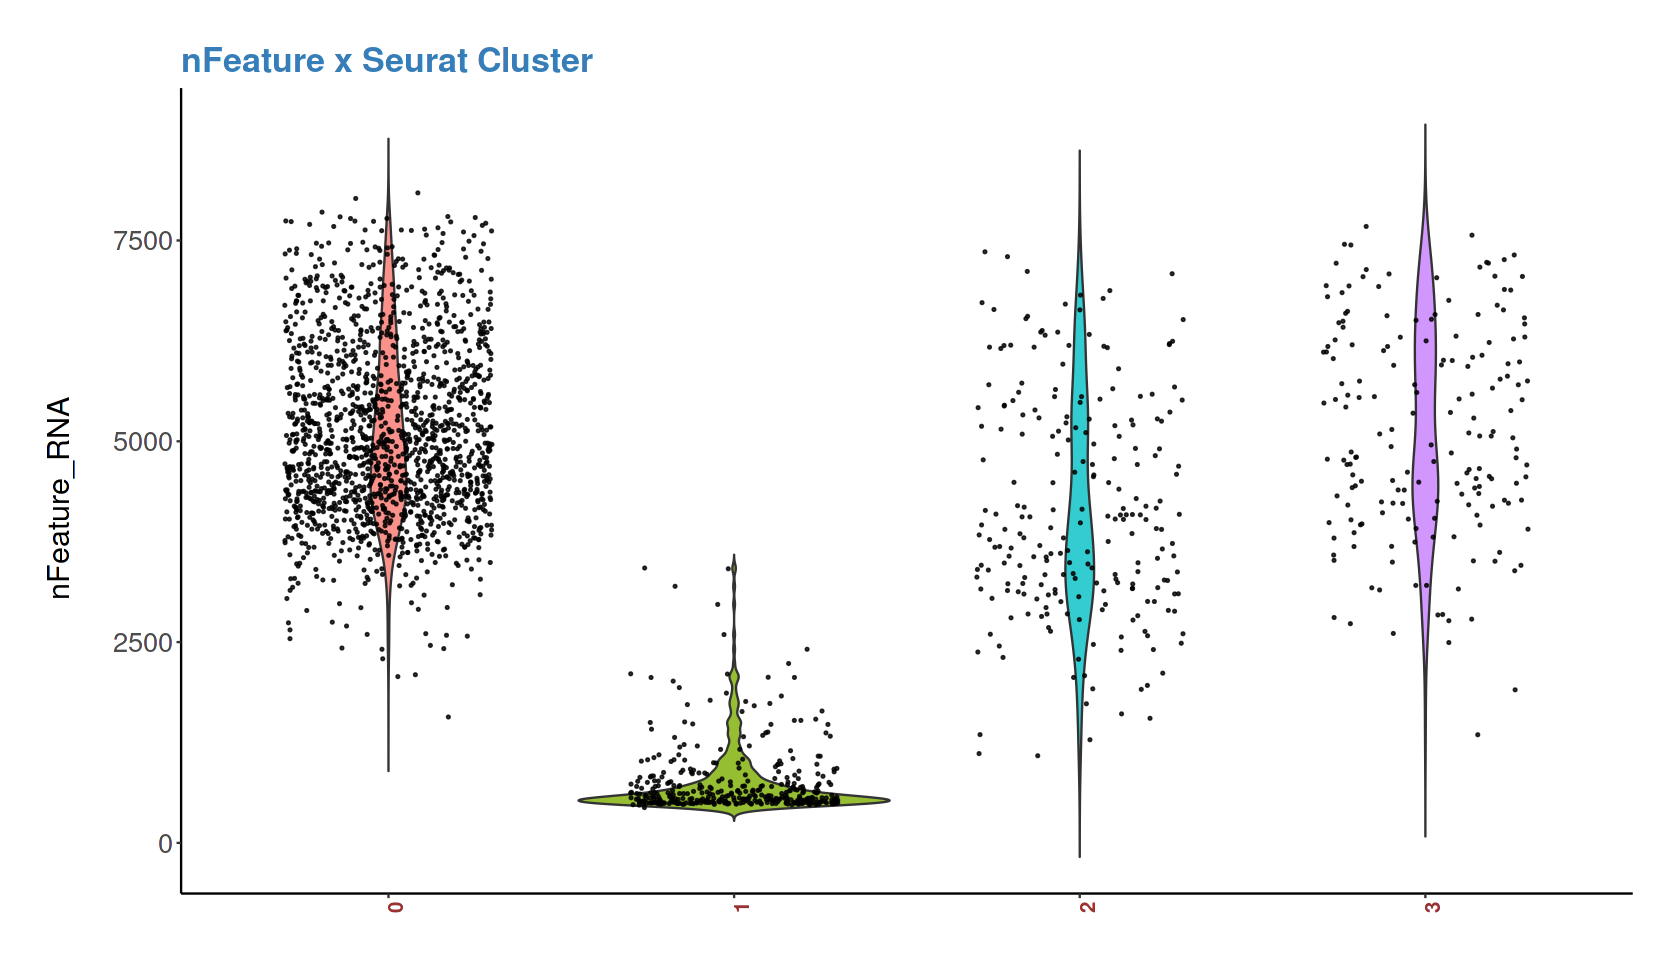

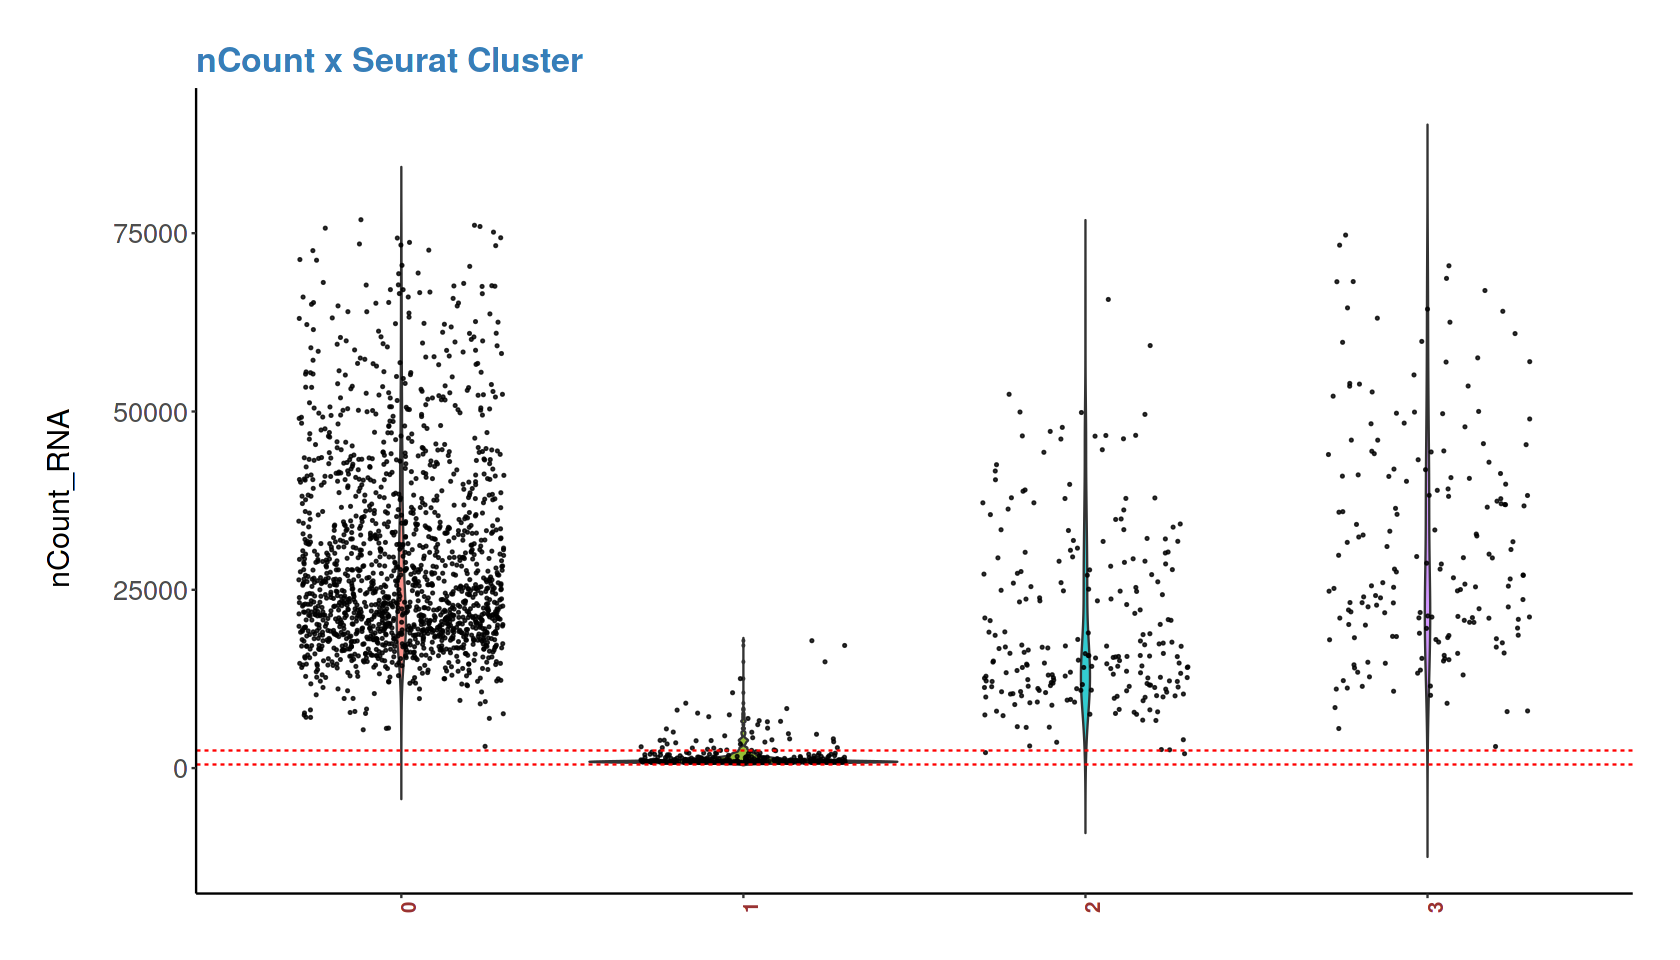

In [76]:
options(repr.plot.width=14, repr.plot.height=8)
ggplot(data = metadata, 
       aes(x = seurat_clusters, y = (nFeature_RNA), fill= seurat_clusters)) +
  # The half violins
  geom_violin(position = position_nudge(x = 0, y = 0), alpha = 0.8, trim=FALSE) +
  # The points
  geom_point(aes(y = (nFeature_RNA)),
             position = position_jitter(width = 0.3), size = 0.4, alpha = 0.8) +
  # The boxplots
  # geom_boxplot(width = 0.2, outlier.shape = NA, alpha = 0.6) +
  # \n adds a new line which creates some space between the axis and axis title
  labs(y = "nFeature_RNA  \n", x = NULL) +
  # Removing legends
  guides(fill = FALSE, color = FALSE) +
  # Setting the limits of the y axis
  #scale_y_continuous(limits = c(25, 40)) +
  # Picking nicer colours
  #scale_fill_manual(values = colours) +
  #scale_x_discrete(labels=as.character(labels_beforeQC)) +
  theme_niwot() +
  # geom_hline(yintercept=1000, linetype="dashed", color = "red") +
  ggtitle("nFeature x Seurat Cluster") +
  theme(axis.text.x = element_text(face="bold", color="#993333", 
                           size=12, angle=90),
       plot.title = element_text(color="#377eb8", size=20, face="bold"))

ggplot(data = metadata, 
       aes(x = seurat_clusters, y = (nCount_RNA), fill= seurat_clusters)) +
  # The half violins
  geom_violin(position = position_nudge(x = 0, y = 0), alpha = 0.8, trim=FALSE) +
  # The points
  geom_point(aes(y = (nCount_RNA)),
             position = position_jitter(width = 0.3), size = 0.4, alpha = 0.8) +
  # The boxplots
  # geom_boxplot(width = 0.2, outlier.shape = NA, alpha = 0.6) +
  # \n adds a new line which creates some space between the axis and axis title
  labs(y = "nCount_RNA  \n", x = NULL) +
  # Removing legends
  guides(fill = FALSE, color = FALSE) +
  # Setting the limits of the y axis
  #scale_y_continuous(limits = c(25, 40)) +
  # Picking nicer colours
  #scale_fill_manual(values = colours) +
  #scale_x_discrete(labels=as.character(labels_beforeQC)) +
  theme_niwot() +
  geom_hline(yintercept=2500, linetype="dashed", color = "red") +
  geom_hline(yintercept=500, linetype="dashed", color = "red") +
  ggtitle("nCount x Seurat Cluster") +
  theme(axis.text.x = element_text(face="bold", color="#993333", 
                           size=12, angle=90),
       plot.title = element_text(color="#377eb8", size=20, face="bold"))

Need to remove cluster 1

# Removing cluster with low nCount

In [77]:
# To subset and remove single cluster and keep the remaining clusters for new analysis
Gastruloid_72h_afterQC <- subset(Gastruloid_72h_afterQC, idents = 1, invert = TRUE)


## Reclustering the data after removing cluster

In [79]:
x <- NormalizeData(Gastruloid_72h_afterQC, verbose = FALSE)
x <- FindVariableFeatures(x, verbose = FALSE)
x <- ScaleData(x, verbose = FALSE)
x <- RunPCA(x, verbose = FALSE)
x <- RunUMAP(x, dims = 1:30, n.neighbors=10)
x <- FindNeighbors(x, dims = 1:20)
x <- FindClusters(x, resolution = 0.3)

16:28:38 UMAP embedding parameters a = 0.9922 b = 1.112

16:28:38 Read 1978 rows and found 30 numeric columns

16:28:38 Using Annoy for neighbor search, n_neighbors = 10

16:28:38 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:28:38 Writing NN index file to temp file /scratch/local/RtmpirVYrV/fileb99323c8c28d

16:28:38 Searching Annoy index using 1 thread, search_k = 1000

16:28:38 Annoy recall = 100%

16:28:39 Commencing smooth kNN distance calibration using 1 thread

16:28:40 Initializing from normalized Laplacian + noise

16:28:40 Commencing optimization for 500 epochs, with 26930 positive edges

16:28:42 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1978
Number of edges: 72551

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8170
Number of communities: 4
Elapsed time: 0 seconds


In [81]:
Gastruloid_72h_afterQC <- x

# Saving the data

In [88]:
metadata_72h_afterQC <- Gastruloid_72h_afterQC@meta.data

In [89]:
# Save the files
saveRDS(Gastruloid_72h_afterQC, file = "./files/Seurat_Obj_afterQC/SeuratClustering_individual_timepoints/Gastruloid_72h_afterQC.rds")
saveRDS(metadata_72h_afterQC, file = "./files/Seurat_Obj_afterQC/SeuratClustering_individual_timepoints/metadata_72h_afterQC.rds")